In [1]:
!pip install mediapipe


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 269 kB/s 


In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [3]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [4]:
photo_names = [file for file in os.listdir("/content/AFLW2000") if file.endswith(".jpg")]


In [5]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [6]:
# set data for all images using mediapipe
imgs_data = []
for i in range(len(photo_names)):
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image_path = '/content/AFLW2000/'+photo_names[i]
      image = cv2.imread(image_path)
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks is not None: 
        # take only first face captured
        face = results.multi_face_landmarks[0]
        dimensions = []
        #dimensions.append(photo_names[i])
        for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            # normalized x and y vals
            dimensions = dimensions + [x, y]
        
        mat_file = sio.loadmat(image_path.strip('.jpg') +'.mat')
        # extracting the labels 3 angels
        pose_para = mat_file["Pose_Para"][0][:3]
        pitch = pose_para[0]
        yaw = pose_para[1]
        roll = pose_para[2]
        dimensions = dimensions + [pitch, yaw, roll]
        imgs_data.append(dimensions)

In [7]:
df = pd.DataFrame(imgs_data)

In [8]:
df

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,936,937,938
0,0.448754,0.656890,0.418689,0.590842,0.444155,0.615272,0.414519,0.540589,0.414397,0.572191,...,0.497754,0.476211,0.500643,0.576674,0.466314,0.588206,0.456244,0.171752,0.636963,-0.122694
1,0.524299,0.654976,0.556138,0.608479,0.532756,0.621761,0.540172,0.552551,0.560312,0.592039,...,0.512836,0.550949,0.516380,0.606670,0.504229,0.612946,0.497414,-0.131739,-0.516555,0.183045
2,0.481340,0.702374,0.479999,0.616802,0.487799,0.643953,0.474284,0.539957,0.481149,0.592342,...,0.492416,0.554461,0.495673,0.699269,0.480261,0.713179,0.468795,0.125778,0.136994,0.078335
3,0.519243,0.663119,0.549312,0.604009,0.530375,0.622777,0.540996,0.542414,0.555569,0.585744,...,0.516019,0.572935,0.517553,0.654161,0.526009,0.662894,0.521066,-0.015460,-0.340136,0.215889
4,0.524361,0.717719,0.516385,0.635057,0.520145,0.655488,0.489452,0.541296,0.514494,0.608619,...,0.462973,0.559919,0.470022,0.714684,0.435729,0.728277,0.420972,-0.132246,0.133910,-0.000346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.504090,0.676269,0.476378,0.626752,0.492636,0.640910,0.459962,0.558249,0.472019,0.606476,...,0.497008,0.512953,0.501812,0.623424,0.461359,0.632632,0.452058,-0.107574,0.334741,-0.166388
1849,0.537670,0.655519,0.547923,0.599958,0.533332,0.616351,0.518118,0.548055,0.547741,0.583371,...,0.501210,0.529540,0.505301,0.595221,0.473705,0.601171,0.467461,-0.113956,-0.391885,-0.102590
1850,0.502400,0.690067,0.521441,0.625629,0.509357,0.643490,0.503142,0.554948,0.523840,0.604630,...,0.499759,0.540161,0.504605,0.641151,0.476985,0.649424,0.469195,-0.217898,-0.212085,0.035913
1851,0.492854,0.628528,0.531507,0.616141,0.513687,0.611495,0.556504,0.570429,0.543054,0.609653,...,0.568451,0.592051,0.568787,0.638897,0.621140,0.648150,0.622100,-0.379047,-0.301894,1.106254


In [9]:
df.columns = [*df.columns[:-3], 'pitch', 'yaw', 'roll']

In [10]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
0,0.448754,0.656890,0.418689,0.590842,0.444155,0.615272,0.414519,0.540589,0.414397,0.572191,...,0.497754,0.476211,0.500643,0.576674,0.466314,0.588206,0.456244,0.171752,0.636963,-0.122694
1,0.524299,0.654976,0.556138,0.608479,0.532756,0.621761,0.540172,0.552551,0.560312,0.592039,...,0.512836,0.550949,0.516380,0.606670,0.504229,0.612946,0.497414,-0.131739,-0.516555,0.183045
2,0.481340,0.702374,0.479999,0.616802,0.487799,0.643953,0.474284,0.539957,0.481149,0.592342,...,0.492416,0.554461,0.495673,0.699269,0.480261,0.713179,0.468795,0.125778,0.136994,0.078335
3,0.519243,0.663119,0.549312,0.604009,0.530375,0.622777,0.540996,0.542414,0.555569,0.585744,...,0.516019,0.572935,0.517553,0.654161,0.526009,0.662894,0.521066,-0.015460,-0.340136,0.215889
4,0.524361,0.717719,0.516385,0.635057,0.520145,0.655488,0.489452,0.541296,0.514494,0.608619,...,0.462973,0.559919,0.470022,0.714684,0.435729,0.728277,0.420972,-0.132246,0.133910,-0.000346


In [11]:
def sub_preproc(df, landmark_no):
  # x, and y columns for landmark with given formula
  pivot_x = landmark_no + (landmark_no - 2)
  pivot_y = pivot_x + 1

  # get x and y column labels
  all_x_corr = [i for i in df.columns[:-3] if i % 2== 0]
  all_y_corr = [i for i in range(1, df.shape[1] - 3, 2)]
  
  all_x_corr.remove(pivot_x)
  all_y_corr.remove(pivot_y)
  # subtract pivot column from each row using broadcasting
  df.loc[:, all_x_corr] = df.loc[:, all_x_corr].values - df.loc[:, pivot_x].values.reshape(df.shape[0], 1)
  df.loc[:, all_y_corr] = df.loc[:, all_y_corr].values - df.loc[:, pivot_y].values.reshape(df.shape[0], 1)

  # return df

  


In [12]:
df_clean = df.copy()

In [13]:
sub_preproc(df_clean, 6);

In [14]:
df_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
0,0.030490,0.106009,0.000424,0.039961,0.025890,0.064391,-0.003746,-0.010292,-0.003867,0.021310,...,-0.053127,0.057946,-0.050238,0.158410,-0.084567,0.169941,-0.094637,0.171752,0.636963,-0.122694
1,-0.033460,0.084970,-0.001621,0.038473,-0.025003,0.051755,-0.017587,-0.017455,0.002553,0.022033,...,-0.057169,-0.006810,-0.053625,0.048911,-0.065777,0.055187,-0.072592,-0.131739,-0.516555,0.183045
2,-0.005692,0.140417,-0.007032,0.054844,0.000767,0.081996,-0.012747,-0.022000,-0.005882,0.030385,...,-0.069542,0.067429,-0.066284,0.212237,-0.081697,0.226147,-0.093163,0.125778,0.136994,0.078335
3,-0.038496,0.100765,-0.008428,0.041654,-0.027365,0.060422,-0.016743,-0.019941,-0.002171,0.023390,...,-0.046336,0.015195,-0.044801,0.096421,-0.036345,0.105154,-0.041288,-0.015460,-0.340136,0.215889
4,0.011489,0.147070,0.003514,0.064407,0.007274,0.084839,-0.023419,-0.029353,0.001622,0.037970,...,-0.107677,0.047047,-0.100627,0.201812,-0.134921,0.215405,-0.149677,-0.132246,0.133910,-0.000346


In [15]:
x = df_clean.loc[:, df_clean.columns[:-3]]
y = df_clean.loc[:, df_clean.columns[-3:]]

In [16]:
'''# choosing landmark of nose
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              #print(x)
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
              #input()
              time.sleep(2.4)
              cv2_imshow(image)'''

"# choosing landmark of nose\nrandom_file = 'image00053'\n\nfaceModule = mediapipe.solutions.face_mesh\n# loading image and its correspinding mat file\nwith faceModule.FaceMesh(static_image_mode=True) as faces:\n    # loading the image\n    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')\n    # processing the face to extract the landmark points (468 point) for each x,y,z\n    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))\n    if results.multi_face_landmarks != None: \n      # looping over the faces in the image\n      for face in results.multi_face_landmarks:\n          for landmark in face.landmark:\n              x = landmark.x\n              y = landmark.y\n              #print(x)\n              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image\n              shape = image.shape \n              relative_x = int(x * shape[1])\n              relative_y = int(y * shape[0])\n             

# **Model Training**

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [55]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

In [56]:
# divide labels for three models
yaw_train = y_train['yaw']
roll_train = y_train['roll']
pitch_train = y_train['pitch']

yaw_test = y_test['yaw']
roll_test = y_test['roll']
pitch_test = y_test['pitch']



In [38]:
def grid_eval(model, x_test, y_test):
  print("best parameters for model:", model.best_params_)
  print("best score :", model.best_score_)
  print("r2 score on test set:", r2_score(y_test, model.predict(x_test)))
  # or model.score(x_test, y_test)


In [59]:
'''0.0001 < gamma < 10

0.1 < c < 100
'''
## 'epsilon':[0.1,0.2,0.5,0.3]
parameters = {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100, 1000],'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'epsilon':[0.1,0.2,0.5,0.3]}
# , scoring = ''  ‘r2’   ‘neg_mean_squared_error’

# using default scorer for sklearn : r2 score
# param_grid = parameters
yaw_model = GridSearchCV(SVR(), parameters, cv= 5 , n_jobs=-1)
pitch_model = GridSearchCV(SVR(), parameters, cv= 5 , n_jobs=-1)
roll_model = GridSearchCV(SVR(), parameters, cv= 5 , n_jobs=-1)

In [ ]:
yaw_model.fit(X_train, yaw_train)

In [58]:
grid_eval(yaw_model, X_test, yaw_test)

best parameters for model: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
best score : 0.9231467990775215
r2 score on test set: 0.8693467279799163


In [43]:
yaw_model.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [28]:
# saving model
joblib.dump(yaw_model, 'yaw.pkl')

['yaw.pkl']

In [29]:
# train pitch model

In [98]:
pitch_model.fit(X_train, pitch_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'epsilon': [0.1, 0.2, 0.5, 0.3],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']})

In [57]:
grid_eval(pitch_model, X_test, pitch_test)

best parameters for model: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
best score : 0.5843943740068313
r2 score on test set: 0.8201131351689792


In [45]:
pitch_model.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [37]:
# train roll model

In [ ]:
roll_model.fit(X_train, roll_train);

In [46]:
roll_model.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [59]:
grid_eval(roll_model, X_test, roll_test)

best parameters for model: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
best score : 0.6618646803985677
r2 score on test set: 0.8101553904702432


### SVR does not give good results with pitch and roll models

train on whole dataset as size is small

In [ ]:
'''from joblib import Parallel, delayed
import joblib
 
 
# Save the model as a pickle in a file
joblib.dump(knn, 'filename.pkl')
 
# Load the model from the file
knn_from_joblib = joblib.load('filename.pkl')
 
# Use the loaded model to make predictions
knn_from_joblib.predict(X_test)'''

# Train random forest

In [30]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [50, 55, 60, 70, 75, 80, 90, 94, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# [5, 8, 15, 25, 30]
max_depth = [int(x) for x in np.linspace(1, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10] 

bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [31]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(x, y['pitch'])

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [1, 5, 10, 15, 20, 25, 30,
                                                      35, 40, 45, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [50, 55, 60, 70, 75, 80,
                                                         90, 94, 100]},
                   random_state=42)

In [35]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 100,
 'n_estimators': 55}

In [36]:
rf_random.best_score_

0.18905768912396534

train pitch model

In [63]:
forest_pitch = RandomForestRegressor(n_estimators = 50)
forest_pitch.fit(x, y['pitch'])

RandomForestRegressor(n_estimators=50)

In [64]:
r2_score(y['pitch'], forest_pitch.predict(x))

0.8565444283383893

In [124]:
forest_pitch.get_params() 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [60]:
# saving model
joblib.dump(forest_pitch, 'forest_pitch.pkl')

['forest_pitch.pkl']

roll model train

In [233]:
forest_roll = RandomForestRegressor()
forest_roll.fit(x, y['roll'])

RandomForestRegressor()

In [234]:
r2_score(y['roll'], forest_roll.predict(x))

0.8844994664656501

In [ ]:
# saving model
joblib.dump(forest_pitch, 'forest_roll.pkl')

picked yaw model trained using SVR

picked pitch, roll models trained using random forest regression

# Testing on a new photo

In [72]:
def pred_features(img_name):
  '''takes an image name in directory as input returns a pandas dataframe of featres'''
  dims = []

  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      
      image = cv2.imread('/content/' + img_name+ '.jpg')
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                dims.append(x)
                dims.append(y)
  
  dims_df = pd.DataFrame(dims).T  
  sub_preproc(dims_df, 6)

  return dims_df              



def draw_image(img_name, features_df = None):
  if not features_df:
    features_df = pred_features(img_name)
  image = cv2.imread('/content/' + img_name+ '.jpg')
  cv2_imshow(draw_axis(image, forest_pitch.predict(features_df)[0], yaw_model.predict(features_df)[0], forest_roll.predict(features_df)[0]))


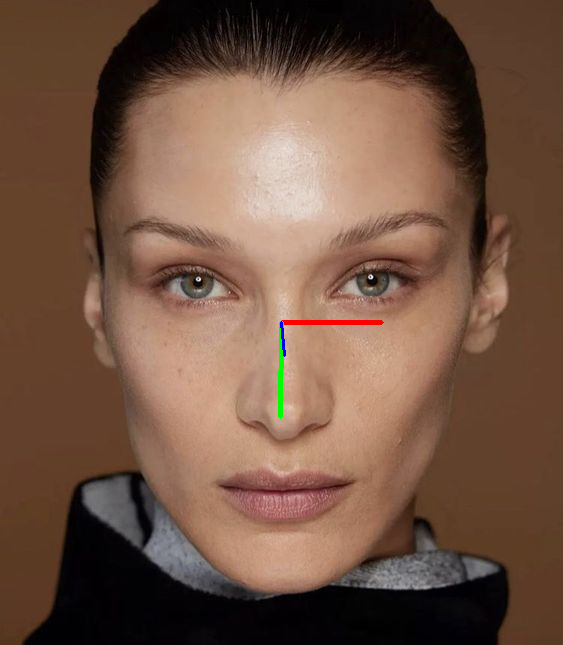

In [78]:
draw_image('bella')